In [1]:
from music21 import converter, instrument, note, chord, stream
import glob
import pickle
import numpy as np

## Read a Midi File

In [2]:
song1 = converter.parse("midi_songs/8.mid")
print(type(song1))

<class 'music21.stream.base.Score'>


In [3]:
song1

<music21.stream.Score 0x223b220e040>

In [4]:
# song1 --> object of stream.Score type
#       --> will contain music in form of notes and chords
song1.show('midi') # Shows the song in playable format

In [5]:
# So, the chords and notes are stored in nested forms of containers
# .. to simplify this, store all of them in a single list
# ==> Flatten the elements.
elements_of_song = song1.flat.notes
print(len(elements_of_song))
print(elements_of_song)
print(type(elements_of_song))

336
<music21.stream.iterator.StreamIterator for Score:0x223cbdea760 @:0>
<class 'music21.stream.iterator.StreamIterator'>


In [6]:
count = 0
print("Following are some elements of song :-")
for e in elements_of_song:
    print(e, e.offset, type(e))
    count += 1
    if count > 7:
        break
    # e.offset --> will tell the time-duration of element

Following are some elements of song :-
<music21.note.Note C> 0.0 <class 'music21.note.Note'>
<music21.chord.Chord C5 E4> 0.0 <class 'music21.chord.Chord'>
<music21.note.Note C> 0.0 <class 'music21.note.Note'>
<music21.note.Note C> 0.0 <class 'music21.note.Note'>
<music21.chord.Chord C5 E4> 0.0 <class 'music21.chord.Chord'>
<music21.note.Note C> 0.0 <class 'music21.note.Note'>
<music21.note.Note G> 1.5 <class 'music21.note.Note'>
<music21.note.Note G> 5/3 <class 'music21.note.Note'>


## Get All the Notes, from all the Midi Files

In [7]:
notes = []
count = 0
for file in glob.glob("midi_songs/*.mid"):
    midi = converter.parse(file) # Convert file into stream.Score Object
    if count < 10:
        print("parsing %s"%file)    
    elements_to_parse = midi.flat.notes
    count += 1

    for elex in elements_to_parse:
        # If the element is a Note,  then store it's pitch
        if(isinstance(elex, chord.Chord) == True):
            notes.append("+".join(str(n) for n in elex.normalOrder))
        elif(isinstance(elex, note.Note) == True):
            noteString = str(elex.pitch)
            notes.append(noteString)
            # If the element is a Chord, split each note of chord and join them with +
print("...")

parsing midi_songs\0fithos.mid
parsing midi_songs\8.mid
parsing midi_songs\ahead_on_our_way_piano.mid
parsing midi_songs\AT.mid
parsing midi_songs\balamb.mid
parsing midi_songs\bcm.mid
parsing midi_songs\BlueStone_LastDungeon.mid
parsing midi_songs\braska.mid
parsing midi_songs\caitsith.mid
parsing midi_songs\Cids.mid
...


In [8]:
print("Length of notes-array = ", len(notes))
print("Some elements of note array :-")
count = 0
for n in notes:
    print(n)
    count += 1
    if count > 7:
        break
print("...")

Length of notes-array =  60764
Some elements of note array :-
4+9
E2
4+9
4+9
4+9
4+9
4+9
4+9
...


## Saving the file, containing all Notes

In [9]:
import pickle

with open("notes", 'wb') as filepath:
    pickle.dump(notes, filepath)

In [10]:
# 'wb' --> Write-binary mode (to write data in a file)
# 'rb' --> Read-binary mode (to read data from a file)
with open("notes", 'rb') as f:
    notes = pickle.load(f)
    # This will load whole file-data to variable notes

#### Count of Unique Elements in Music :-

In [11]:
# In 'wb' and 'rb', same file needs to be referenced.
# Else, Will give error --> "Ran out of data".
print(len(set(notes)))
# This will print unique no. of elements.
# i.e. --> Unique notes/chords in all files.
numElements = len(set(notes))

398


## Preparing Sequential Data for LSTM :-

In [12]:
sequenceLength = 100
uniqueNotes = sorted(set(notes))
countNodes = len(uniqueNotes)
print("No. of elements in uniqueNotes = ", len(uniqueNotes))
print("Some elements of uniqueNotes array are :-")
count = 0
for ele in uniqueNotes:
    print(ele)
    count += 1
    if count > 7:
        break
print("...")

No. of elements in uniqueNotes =  398
Some elements of uniqueNotes array are :-
0
0+1
0+1+3
0+1+5
0+1+6
0+2
0+2+3+7
0+2+4+5
...


#### Mapping Strings (unique-elements) to Integer values :-

In [13]:
# As ML models work with numerial data only, will map each string with a number.
noteMap = dict((ele, num) for num, ele in enumerate(uniqueNotes))
count = 0
for ele in noteMap:
    print(ele, " : ", noteMap[ele])
    count += 1
    if count > 7:
        break
print("...")

0  :  0
0+1  :  1
0+1+3  :  2
0+1+5  :  3
0+1+6  :  4
0+2  :  5
0+2+3+7  :  6
0+2+4+5  :  7
...


--> As sequenceLength is 100, will take first 100 data to input, and 101st data as output.
--> For next iteration, take (2-101) data points as input, and 102nd data as output.
--> So on...  Sliding window (of size 100) as input, & next 1 data as output.

--> So, total we will get (len(notes) - sequenceLength) datapoints.

In [14]:
networkInput = [] # input-data
networkOutput = [] # will try to get output, using input
for i in range(len(notes) - sequenceLength):
    inputSeq = notes[i : i+sequenceLength] # 100 string-values
    outputSeq = notes[i + sequenceLength] # 1 string-value
    # Currently, inputSeq & outputSeq has strings.
    # Use map, to convert it to integer-values.
    # ..as ML-algorithm works only on numerical data.
    networkInput.append([noteMap[ch] for ch in inputSeq])
    networkOutput.append(noteMap[outputSeq])

In [15]:
print(len(networkInput))
print(len(networkOutput))

60664
60664


#### Create ready-data for Neural Network :-

In [16]:
import numpy as np

In [17]:
# n_patterns = int(len(networkInput)/100)
# No. of rows divided by 100.. as 100 columns, so Distributing data in 3-D format
n_patterns = len(networkInput)
networkInput = np.reshape(networkInput, (n_patterns, sequenceLength, 1))
# LSTM recieves input data in 3-dimensions
print(networkInput.shape)

(60664, 100, 1)


#### Normalize this data

In [18]:
# As the values are from 0 - uniqueNodes
# For better precision, converting data in range [0 - 1]
normNetworkInput = networkInput / float(numElements)
print("Some elements of normNetworkInput[0] array :-")
count = 0
for ele in normNetworkInput[0]:
    print(ele)
    count += 1
    if count > 10:
        break
print("...")

Some elements of normNetworkInput[0] array :-
[0.48743719]
[0.92713568]
[0.48743719]
[0.48743719]
[0.48743719]
[0.48743719]
[0.48743719]
[0.48743719]
[0.48743719]
[0.2638191]
[0.48743719]
...


In [19]:
# Now, values are in range [0 - 1]
# Network output are the classes, encoded into 1-vector

In [20]:
from keras.utils import np_utils

In [21]:
networkOutput = np_utils.to_categorical(networkOutput)
print(networkOutput.shape)
# This will convert output-data to a 2-D format
# In which each key(old-output value) has 229 categorical values
# And, the one which matches has some kind of flag marked to it.

(60664, 398)


# Create Model

#### Download & Import Packages

In [22]:
from keras.models import Sequential
from keras.layers import *
from keras.callbacks import ModelCheckpoint, EarlyStopping

### Creating a Sequential Model :-

In [23]:
model = Sequential()

### Adding Layers to the Model :-

In [39]:
# And, this model has first layer as LSTM layer.
model.add(LSTM(units=512, input_shape=(normNetworkInput.shape[1], normNetworkInput.shape[2]), return_sequences=True))
# As this is the 1st layer, so we need to provide the input-shape (in argument)
# Here we are passing (100,1) as input_shape, as all data-points have shape (100,1)
# Also, we have to do return_sequences=True, as this isn't the last layer, also have further layers.

# After the 1st layer, adding a Dropout
model.add(Dropout(0.3))

# Also adding another LSTM layer.
model.add(LSTM(512, return_sequences=True))
# return_sequences=True --> returns only last output of output seq.

# Again adding a Dropout
model.add(Dropout(0.3))

# And, now 1-more LSTM layer.
model.add(LSTM(512))
# return_sequences=False(default) --> returns whole output-seq.

# And, adding a Dense-layer.
model.add(Dense(256))

# Again adding a Dropout.
model.add(Dropout(0.3))

# Now, the final layer.
#   (Adding dense layer with no. of neurons = countNodes)
#   (Also having an "softmax" activation function)
model.add(Dense(numElements, activation="softmax"))

#### Compiling the model :-

In [40]:
model.compile(loss="categorical_crossentropy", optimizer="adam")
# loss="categorical_crossentropy" --> since it has 229 classes.
# Not specifying any metrics (like accuracy), as it would not be a good metrics to evaluate.

### This is our Model :-

In [42]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 512)          1052672   
                                                                 
 dropout (Dropout)           (None, 100, 512)          0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 512)          2099200   
                                                                 
 dropout_1 (Dropout)         (None, 100, 512)          0         
                                                                 
 lstm_2 (LSTM)               (None, 512)               2099200   
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0

### Training the Model :-

In [41]:
import tensorflow as tf

In [52]:
# (Entire code commented out, to prevent created model, from starting fit again, and old work getting wasted)
# Creating callbacks for fitting model.

checkpoint = ModelCheckpoint("model3.hdf5", monitor='loss', verbose=0, save_best_only=True, mode='min')
# 1st arg  -->  where the model will be saved
# 2nd arg  -->  We have to monitor the loss
# 5th arg  -->  As monitoring loss, so mode = "min", as loss should be minimum.

# We can also create an earlystopping callback, but lets only keep the checkpoint.

# Fitting the model :-

model_his = model.fit(normNetworkInput, networkOutput, epochs=10, batch_size=64, callbacks=[checkpoint])
# No. of epochs = 10 (trying for model3)
# batch size = 64
# No. of epochs = 100 (for model4 .. trained in google-colab)
# Then imported that model to this file...

Epoch 1/10
948/948 [==============================] - 4003s 4s/step - loss: 4.8030
Epoch 2/10
948/948 [==============================] - 3837s 4s/step - loss: 4.7745
Epoch 3/10
948/948 [==============================] - 3842s 4s/step - loss: 4.7721
Epoch 4/10
948/948 [==============================] - 3839s 4s/step - loss: 4.7687
Epoch 5/10
948/948 [==============================] - 12148s 13s/step - loss: 4.7669
Epoch 6/10
948/948 [==============================] - 3739s 4s/step - loss: 4.7658
Epoch 7/10
948/948 [==============================] - 3994s 4s/step - loss: 4.7650
Epoch 8/10
948/948 [==============================] - 3497s 4s/step - loss: 4.7646
Epoch 9/10
948/948 [==============================] - 3606s 4s/step - loss: 4.7646
Epoch 10/10
948/948 [==============================] - 3747s 4s/step - loss: 4.7644


## Load Model :-

In [42]:
from keras.models import load_model

In [43]:
model = load_model("model4.hdf5")

## Predictions :-

In [44]:
sequenceLength = 100

In [45]:
networkInput = [] # input-data
for i in range(len(notes) - sequenceLength):
    inputSeq = notes[i : i+sequenceLength] # 100 string-values
    # Currently, inputSeq & outputSeq has strings.
    # Use map, to convert it to integer-values.
    # ..as ML-algorithm works only on numerical data.
    networkInput.append([noteMap[ch] for ch in inputSeq])

In [46]:
print("Some elements of networkInput[0] array :-")
count = 0
for ele in networkInput[0]:
    print(ele)
    count += 1
    if count > 7:
        break
print("...")

Some elements of networkInput[0] array :-
194
369
194
194
194
194
194
194
...


In [47]:
print(len(networkInput[300]))

100


In [48]:
# Each data-point has 100-elements (in networkInput)
# We will give these 100-elements as input, & it will generate 1-output.
# Will add this 1-output in input, & discard oldest element from input. (again getting to 100 input-elements)
# This way, we will keep predicting 1-element each time.

In [49]:
startIdx = np.random.randint(len(networkInput)-1)
# This will get any random data-point-index from the input-data
# Data at each random data-point-index means --> 100 elements.

In [50]:
print(startIdx)

16473


In [51]:
networkInput[startIdx]
print("Some elements of networkInput[startIdx] array are :-")
count = 0
for ele in networkInput[startIdx]:
    print(ele)
    count += 1
    if count > 7:
        break
print("...")

Some elements of networkInput[startIdx] array are :-
364
394
364
364
394
364
364
394
...


In [52]:
# Above 100-element np-array, is the start sequence.
# Right now, we have :-
# element --> integer  mapping
# What is also required is :-
# integer --> element  mapping.

In [53]:
intNoteMap = dict((num,ele) for num,ele in enumerate(uniqueNotes))
# This will have  (integer --> element) mapping.
# uniqueNotes --> has all unique-elements
# noteMap --> has  (element --> integer) mapping.
# countNodes --> count of unique-elements.

# print(intNoteMap)
# Commented, as this is just "integer" --> "music-element" mapping.

### Generate Input-music in playable format :-

In [54]:
# Taking the initial input-index pattern
pattern = networkInput[startIdx]
predictionOutput = []

In [55]:
inputMusicElements = []
inputMusic = []
inputMusic = (intNoteMap[ele] for ele in pattern)

In [56]:
offset = 0
# offset --> instance-time of particular element (note/chord)
# Have to iterate over all elements of predictionOutput
#   --> Checking whether is a note or chord ?

for element in inputMusic:
    # If element is a chord :-
    if('+' in element) or element.isdigit():
        # Possibilites are like '1+3' or '0'.
        notesInChord = element.split('+')
        # This will get all notes in chord
        tempNotes = []
        for currNote in notesInChord:
            # Creating note-object for each note in chord
            newNote = note.Note(int(currNote))
            # Set it's instrument
            newNote.storedInstrument = instrument.Piano()
            tempNotes.append(newNote)
        # This chord can have x-notes
        # Create a chord-object from list of notes
        newChord = chord.Chord(tempNotes)
        # Adding offset to chord
        newChord.offset = offset
        # Add this chord to music-elements
        inputMusicElements.append(newChord)
    # If element is a note :-
    else:
        # We know that this is a note
        newNote = note.Note(element)
        # Set off-set of note
        newNote.offset = offset
        # Set the instrument of note
        newNote.storedInstrument = instrument.Piano()
        # Add this note to music-elements
        inputMusicElements.append(newNote)
    offset += 0.5
    # Fixing the time-duration of all elements

In [57]:
# For playing them, have to create a stream-object
#    ..from the generated music-elements
midiInputStream = stream.Stream(inputMusicElements)
# Write this midiStream on a midi-file.
midiInputStream.write('midi', fp="testInput8.mid")
# 1st arg  -->  File-type
# 2nd arg  -->  File-name

'testInput8.mid'

In [58]:
midiInputStream.show('midi')

## Making Prediction :-

In [59]:
# Trying to generate (numIteration)-elements of music
numIteration = 200

for noteIdx in range(numIteration):
    predictionInput = np.reshape(pattern, (1,len(pattern), 1))
    predictionInput = predictionInput / float(countNodes)
    # Making prediction
    prediction = model.predict(predictionInput, verbose=0)
    # Taking the element with max. probability
    idx = np.argmax(prediction)
    # index (unique-note index too) corresponding to max. probability element
    result = intNoteMap[idx]
    # Appending this element to prediction-array
    predictionOutput.append(result)
    pattern.append(idx)
    # slicing out the oldest element (0th index)
    pattern = pattern[1:]
    # Size of pattern remained constant at 100 (as needed by model).
    #     (as added 1 element, & removed 1)

In [60]:
print("No. of elements in predictionOutput = ", len(predictionOutput))
print("Some elements of predictionOutput array are :-")
count = 0
for ele in predictionOutput:
    print(ele)
    count += 1
    if count > 7:
        break
print("...")

No. of elements in predictionOutput =  200
Some elements of predictionOutput array are :-
A5
C3
9+11+2+4
0+6
C#3
11+1+4+5
C3
0+4+6
...


### Analyzing Prediction :-

In [61]:
# Let's see, what our model has predicted
print("Measures of Dispersion of data :- \n")
print("Minimum value = ", np.amin(prediction))
print("Maximum value = ", np.amax(prediction))
print("Range of values = ", np.ptp(prediction))
print("Variance = ", np.var(prediction))
print("Standard Deviation = ", np.std(prediction))
print("Length of 1st Prediction-element = ", len(prediction[0]))
print("Count of unique elements = ", countNodes)

Measures of Dispersion of data :- 

Minimum value =  5.747982e-12
Maximum value =  0.89277625
Range of values =  0.89277625
Variance =  0.0022270184
Standard Deviation =  0.047191296
Length of 1st Prediction-element =  359
Count of unique elements =  398


## Generate Music out of Predicted-data :

### What required is to get a Midi File :-

In [62]:
outputMusicElements = []
# Array to store notes & chords.

#### Trying to Create a Note (from string) :-

In [63]:
tempStr = 'C4'
# Just copying from the predictionOutput display
# Creating a note-object (using note-package)
note.Note(tempStr)

<music21.note.Note C>

In [64]:
# Music-note is generated.
# Similarly we can do for multiple elements.
newNote = note.Note(tempStr)
# Also, the note will have a off-set (timing)
# By default, offset was 0. (setting it manually here)
newNote.offset = 0
# And, the note will have an instrument
#    Can set, using storedInstrument package
newNote.storedInstrument = instrument.Piano()
# outputMusicElements.append(newNote)
# Above element is commented out, as it will get unwanted music like this random created note.

In [65]:
print(newNote)

<music21.note.Note C>


#### Creating Music-Elements from String-array :-

In [66]:
offset = 0  # instance-time of particular element (note/chord)

for element in predictionOutput:
    # If element is a chord :-
    if('+' in element) or element.isdigit():
        notesInChord = element.split('+')
        tempNotes = []
        for currNote in notesInChord:
            newNote = note.Note(int(currNote))
            newNote.storedInstrument = instrument.Piano()
            tempNotes.append(newNote)
        # Create a chord-object from list of notes
        newChord = chord.Chord(tempNotes)
        newChord.offset = offset
        # Add this chord to music-elements
        outputMusicElements.append(newChord)
    # If element is a note :-
    else:
        newNote = note.Note(element)
        newNote.offset = offset
        newNote.storedInstrument = instrument.Piano()
        # Add this note to music-elements
        outputMusicElements.append(newNote)
    offset += 0.5

In [67]:
print("No. of elements in outputMusicElements = ", len(outputMusicElements))
print("Some elements of outputMusicElement array are :-")
count = 0
for ele in outputMusicElements:
    print(ele)
    count += 1
    if count > 7:
        break
print("...")

No. of elements in outputMusicElements =  200
Some elements of outputMusicElement array are :-
<music21.note.Note A>
<music21.note.Note C>
<music21.chord.Chord A B D E>
<music21.chord.Chord C F#>
<music21.note.Note C#>
<music21.chord.Chord B C# E F>
<music21.note.Note C>
<music21.chord.Chord C E F#>
...


### Trying to Play the Output Music :-

In [68]:
# For playing them, have to create a stream-object
#    ..from the generated music-elements
midiStream = stream.Stream(outputMusicElements)
# Write this midiStream on a midi-file.
midiStream.write('midi', fp="testOutput8.mid")
# 1st arg  -->  File-type , 2nd arg  -->  File-name

'testOutput8.mid'

#### Loading the output-midi file :

In [69]:
midiStream.show('midi')
# Show the music in playable-format

In [70]:
outputMusic8 = converter.parse("testOutput8.mid")
print(type(outputMusic8))

<class 'music21.stream.base.Score'>


In [71]:
outputMusic8.show('midi')
# This will show the music in playable-format

## Plotting inputMusicElements VS outputMusicElements :

In [72]:
import matplotlib.pyplot as plt

In [73]:
inputMusicNums = networkInput[startIdx]
print("Some elements of inputMusicNums :-")
count = 0
for ele in inputMusicNums:
    print(ele)
    count += 1
    if count > 7:
        break
print("...")

Some elements of inputMusicNums :-
364
394
364
364
394
364
364
394
...


In [74]:
outputMusicNums = []
for ele in predictionOutput:
    outputMusicNums.append(noteMap[ele])
print("Some elements of outputMusicNums are :-")
count = 0
for ele in outputMusicNums:
    print(ele)
    count += 1
    if count > 7:
        break
print("...")

Some elements of outputMusicNums are :-
328
350
318
24
344
91
350
21
...


#### Plot inputMusicNums VS outputMusicNums (prediction visualization) :-

In [75]:
y1 = np.array(inputMusicNums)
y1 = y1[:100]
y2 = np.array(outputMusicNums)
y2 = y2[:100]
print(y1.shape)
print(y2.shape)

(100,)
(100,)


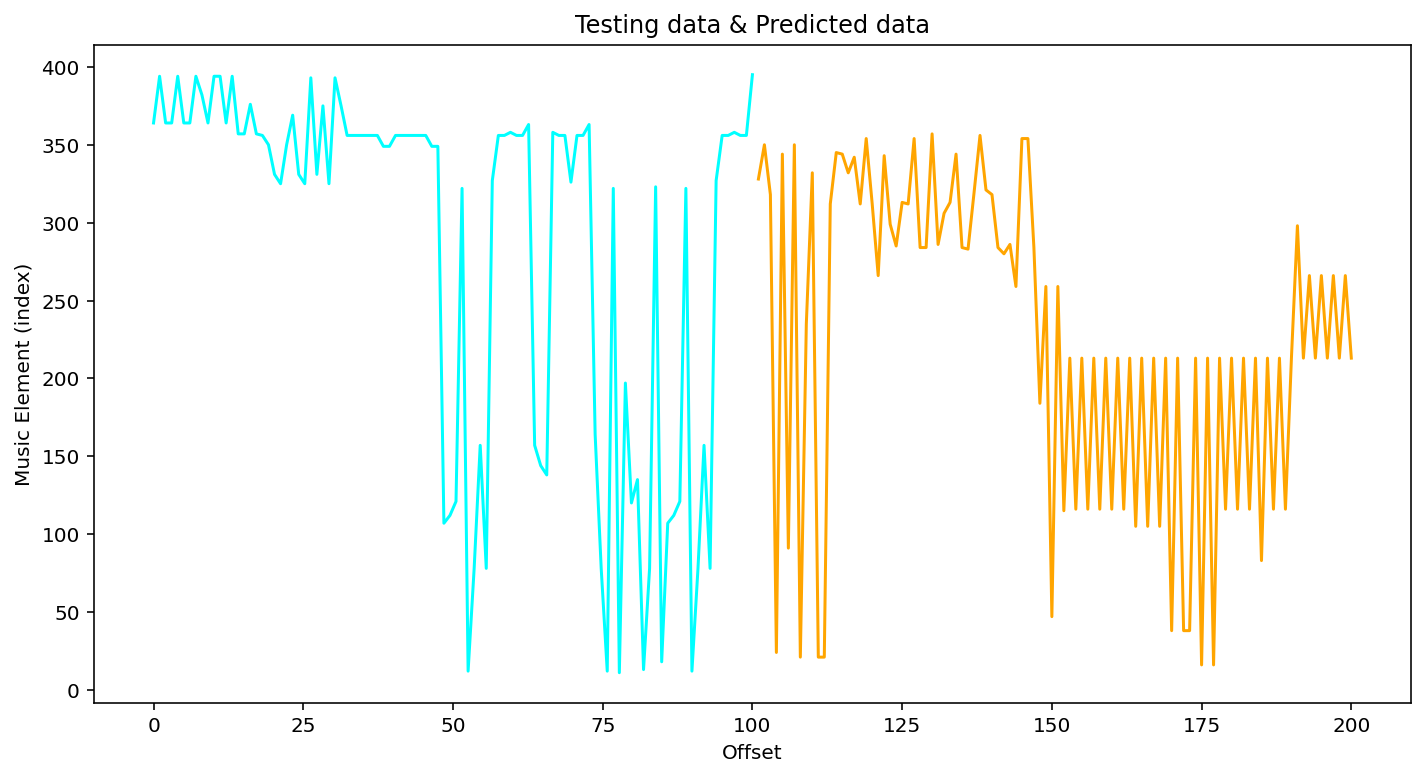

In [76]:
plt.rcParams["figure.figsize"] = [10.00, 5.50]
plt.rcParams["figure.autolayout"] = True
x1 = np.linspace(0,100,100)
x2 = np.linspace(101,200,100)

plt.plot(x1,y1,color="aqua",label="Input music-data")
plt.plot(x2,y2,color="orange",label="Predicted music-data")
plt.xlabel("Offset")
plt.ylabel("Music Element (index)")
plt.title("Testing data & Predicted data")
plt.show()